In [1]:
import pickle
import gzip
import numpy as np
import scipy
import pandas as pd
import keras
import keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.applications import imagenet_utils
from keras import backend as K
from time import time
from keras import losses
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, mean_absolute_error
import glob
from PIL import Image
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp
import pandas as pd
import pickle
from joblib import dump, load
from sklearn.utils import shuffle
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp36-none-any.whl size=3743 sha256=c3eab9e51c990fd23feb897425f0636e3a1d5083ee4b085aa14db23598dcf4f2
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jan  6 17:56:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 215, done.
remote: Total 215 (delta 0), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (215/215), 17.06 MiB | 13.58 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [6]:
import qmc.tf.layers as layers
import qmc.tf.models as models

In [7]:
data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/ICML2021/autompg/data/auto.data', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,-1]
X = X[:,0:-1]

In [8]:
y.shape

(392,)

In [9]:
X.shape

(392, 7)

Los labels van de 1 a 5

In [10]:
print(max(y))
print(min(y))

5.0
1.0


In [11]:
y = (y-1)/4
y = np.float64(y)
y = y.reshape((392,1))
X = np.float64(X)

Normalizando los datos:

In [12]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [13]:
from scipy.spatial import distance

distances = distance.cdist(X, X, 'euclidean')

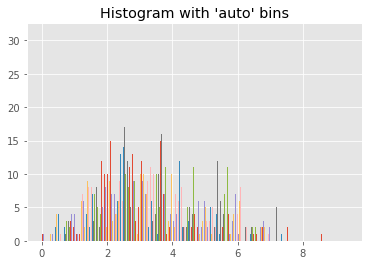

In [14]:
import matplotlib.pyplot as plt

_ = plt.hist(distances, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

Sigma:

In [15]:
print(np.mean(distances))
print(np.median(distances))

3.41515103326364
3.194522475547268


Gamma:

In [16]:
print(1/(np.mean(distances)**2))
print(1/(np.median(distances)**2))

0.08573934673739754
0.09799143192472377


In [18]:
for i in range(10):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/autompg/data/auto.data_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/autompg/data/auto.data_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((200,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    X, y = shuffle(X, y, random_state=0)

    MAE_opt = 100
    dim_y = 5
    for j in range(25):

        beta = np.random.sample()*25
        gamma = np.random.sample()*0.1
        learning_rate = np.random.sample()*0.001
        alpha = np.random.sample()
        dim_x = 7+np.random.sample()*1000
        dim_x = int(dim_x)
        num_eig = np.random.choice([int(dim_x/2),int(dim_x/4),int(dim_x/8), int(dim_x/16)])
        num_eig = int(num_eig)

        print('------------', j+1, 'beta=', beta, 'gamma=', gamma, 'learning_rate=', learning_rate, 'alpha=', alpha, 'dim_x=', dim_x, 'num_eig=', num_eig)

        MAE = []

        fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta)
        fm_x = layers.QFeatureMapRFF(7, dim=dim_x, gamma=gamma, random_state=1)
        qmr2 = models.QMRegressorSGD(input_dim=7, dim_x=dim_x, num_eig=num_eig, dim_y=dim_y, gamma=gamma, random_state=17)

        # for initialize weights

        qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x, dim_y=dim_y)
        
        kf = KFold(n_splits=5)
            
        for train, test in kf.split(X):

            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            qmr.compile()
            qmr.fit(X_train, y_train, epochs=1, batch_size = 4, verbose = 0)

            qmr2.set_rho(qmr.get_rho())
            # Train model with SGD
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            qmr2.layers[0].trainable = True

            def loss(y_true, y_pred):
                return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha * y_pred[:, 1:2]

            qmr2.compile(optimizer, loss=loss)
            qmr2.set_rho(qmr.get_rho())
            early_stop = EarlyStopping( monitor="val_loss",
                                        min_delta=0,
                                        patience=5,
                                        verbose=0,
                                        mode="auto",
                                        restore_best_weights=True,
                                        )

            qmr2.fit(X_train, y_train, epochs=60, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose=0)

            out = qmr2.predict(X_test, batch_size = 4)
            y_pred, std = out[:, 0], np.sqrt(out[:, 1])

            MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
        print('------mae = ',np.mean(MAE))

        if np.mean(MAE) < MAE_opt:
            MAE_opt = np.mean(MAE)
            beta_opt = beta
            gamma_opt = gamma
            learning_rate_opt = learning_rate
            alpha_opt = alpha
            dim_x_opt = dim_x   
            num_eig_opt = num_eig

    print('MAE = ',MAE_opt, 'beta = ',beta_opt, 'gamma = ', gamma_opt, 'learning_rate = ', learning_rate_opt, 'alpha = ', alpha_opt, 'dim_x = ', dim_x_opt, 'num_eig = ', num_eig_opt)

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((192,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(7, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=7, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.mean_squared_error(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

---------------------------------------- 1
------------ 1 beta= 2.862640925938345 gamma= 9.42014448218842e-05 learning_rate= 0.00021754022523431238 alpha= 0.026791334203555395 dim_x= 314 num_eig= 19
------mae =  0.25999999999999995
------------ 2 beta= 13.648665124684333 gamma= 0.07844151029417308 learning_rate= 0.00024711520328713144 alpha= 0.4517264585623214 dim_x= 149 num_eig= 9
------mae =  0.29
------------ 3 beta= 14.08745643381095 gamma= 0.07294182223335348 learning_rate= 0.0004376642824225938 alpha= 0.317861177295787 dim_x= 700 num_eig= 87
------mae =  0.275
------------ 4 beta= 24.045328249524474 gamma= 0.06464360502285803 learning_rate= 0.0007079782995968808 alpha= 0.5314890707020308 dim_x= 389 num_eig= 97
------mae =  0.24499999999999997
------------ 5 beta= 5.862004913735463 gamma= 0.0002159278514368257 learning_rate= 0.0004243154386223369 alpha= 0.9625783621875871 dim_x= 905 num_eig= 56
------mae =  0.4699999999999999
------------ 6 beta= 22.176059213418085 gamma= 6.196348